<h1>Hierarchical clustering of cross-correlation functions </h1>

The following notebook demonstrates how to apply hierarchical clustering to cross-correlation functions following Yates et al. (2023, https://doi.org/10.1093/gji/ggac469) using the Scipy cluster package (i.e. https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage). Notebook uses some functions that are contained within separate script clusterCCFs_msnoise.py. 

The first part reads in cross-correlation functions output by MSNoise. Alternatively, this part can be re-written as long as input into clustering algorithm consists of a numpy array of CCFs.

<h3> 1. Read CCFs output my MSNoise </h3>

Import relevant packages and functions

In [1]:
import os
from matplotlib import cm
from obspy import Stream, Trace, read
from msnoise.api import *
from clusterCCFs_msnoise import *
import matplotlib.pyplot as plt

Define parameters for CCFs that are intended to be clustered (these should correspond to cross-correlation functions already computed in MSNoise, contained within STACKS directory of within user-defined msnoisedir below.

In [2]:
msnoisedir = '/home/yatesal/msnoise/piton04' #set msnoise directory
filterid=2 #set filter id
mov_stack=10 #set stack size
pair = 'YA.UV05.00:YA.UV12.00' #define station pair
startdate = '2010-01-01'
enddate = '2011-04-01'
comp='ZZ' #component to cluster
step = 1 #gap in days between CCFs to cluster

Read CCFs from MSNoise output file, storing in stream object

In [3]:
os.chdir(msnoisedir)
db = connect()
params = get_params(db)

#convert string dates to datetime64
startdatedt = np.datetime64(startdate)
enddatedt = np.datetime64(enddate)

#create array of datetimes between start and enddate, spaced by defined step
days = np.arange(startdatedt, enddatedt, np.timedelta64(step, 'D'))

sta1 = pair.split(":")[0]
sta2 = pair.split(":")[1]

st = Stream()

for i, day in enumerate(days):

    stackpath = "STACKS/{:02d}/{:03d}_DAYS/{}/{}_{}/{}.MSEED".format(filterid,mov_stack,comp,sta1,sta2,day)
    
    if os.path.isfile(stackpath):
        st += read(stackpath)
    else:
        print(stackpath +' missing')


Apply further filtering to CCFs or set filter_ccfs to False to continue without filtering. Convert stream object to numpy array.

In [4]:
filter_ccfs = False
freqmin = 0.1
freqmax = 1.0

st_filt = st.copy()
if filter_ccfs == True:
    st_filt.filter('bandpass',freqmin=freqmin, freqmax=freqmax, zerophase=True)
        
ccfs = np.array(st_filt)   #numpy array of CCFs

<h3>2. Compute distance matrix from ccfs</h3>. 

Define the distance method and run function get_DMatrix() (contained within clusterCCFs_msnoise.py), also defining the lag time of CCFs to cluster.

Currently implemented options in this notebook are 'euclid' (euclidean distance), 'cc' (correlation coefficient, or 1- CC for dissimilarity) and 'ccstretch'. This latter choice will stretch all waveforms relative to eachother, and record the maximum correlation coefficient to calculate dissimilarity (1-max(CC)). The intention here is to 'correct' for larger dv/v changes that could influence clustering results (see supplementary of Yates et al., 2023). Note this increases computation time, so for initial run can be better to go with 'cc'.

For distmethod = 'ccstretch', the values of stretch tested will then be from -dvv_max to +dvv_max in increments of dvv_step. Increasing dvv_max, or reducing dvv_step, will increase computation time. If not using, can leave as they are.

In [5]:
distmethod = 'cc' #euclid, cc, ccstretch

#for distmethod='ccstretch'
dvv_max=0.01 #0.01 = 1%
dvv_step=0.0001
dvvparams = [dvv_max, dvv_step]

minlagwin = 10 #minimum lag
maxlagwin = 40 #maximum lag
sides = 'both' #B (both, default), P (positive), N (negative)
norm=False #normalize CCFs

D = get_DMatrix(ccfs, params, distmethod, minlagwin, maxlagwin, norm=norm, dvvparams=dvvparams)

<h3> 3. Perform agglomerative hierarchical clustering </h3>

Define the linkage method for clustering (can experiment with these). Used average linkage in Yates et al. as appeared more suitable towards isolating tremor episodes at Piton de la Fournaise (see supplementary)... however ward linkage also nice and can give pretty clean results. 

The following code will output the dendrogram showing grouping of CCFs at different distance levels. Can be useful to define cut-off threshold in next part of code (in near-future would like to implement dynamic cut-off threshold).

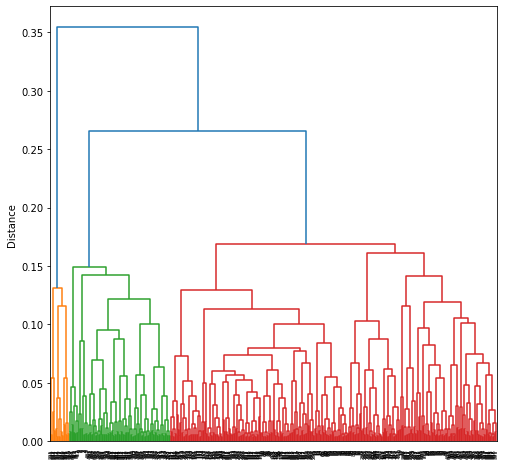

In [6]:
linkagemethod='average' #single, complete, average, ward

fig, ax = plt.subplots(figsize=(8,8))
ax.set_ylabel('Distance')

H = hierarchy.linkage(squareform(D), method=linkagemethod)
dn = hierarchy.dendrogram(H, ax=ax)

<h3> 4. Plot position of clusters in time </h3>

Define a cut-off threshold, and plot interferogram of CCFs and position in time of clusters for this threshold threshold and the corresponding dendrogram.

Note, if a cluster only contains one CCF at the given threshold, there can be some issues with colour scheme (i.e. dendrogram color scheme not matching subplot showing cluster position in time). Plan to fix this later.

Figure(864x864)
AxesSubplot(0.125,0.657941;0.775x0.222059)


/home/yatesal/cluster_CCFs/clusterCCFs_msnoise.py:250: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(df.index, df.columns, df.values.T, vmin=-clim, vmax=clim, rasterized=True,cmap='seismic')


Text(0, 0.5, 'Distance')

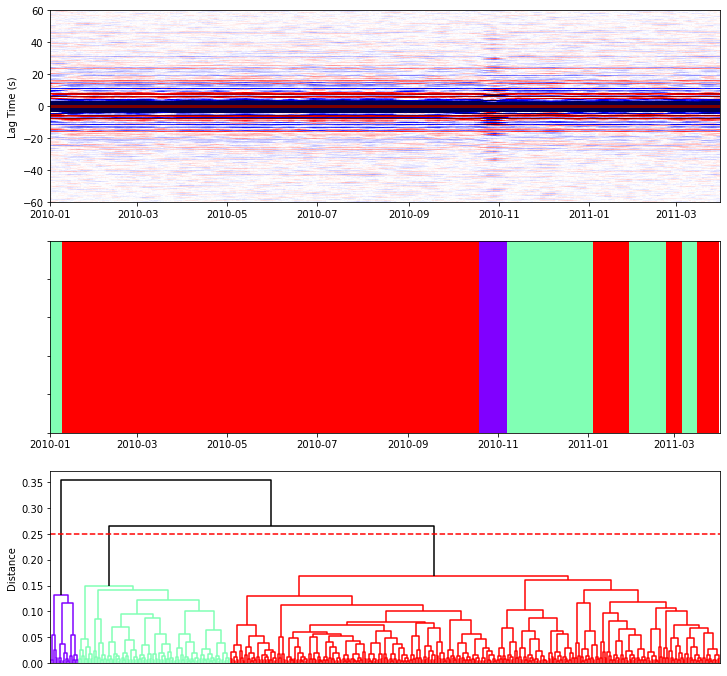

In [9]:
#set static threshold to show location of clusters in time
threshold = 0.25

# Plot interferogram, dendrogram and cluster positions

fig, ax = plt.subplots(3,1, figsize=(12,12))

plot_interferogram(ccfs, params, days, fig=fig, ax=ax[0], maxlag=60)

#get labels corresponding to distance threshold
labels = hierarchy.fcluster(H, threshold, criterion='distance')
num_fam = np.max(labels) #no. clusters
cmap = plt.get_cmap('rainbow')
color_range = cmap(np.linspace(0.0, 1.0, int(num_fam)))

#plot cluster labels
for d in range(len(days)):     
    if d == 0:
        continue
    else:
        diff = (days[d]-days[d-1])/np.timedelta64(1,'D')
        if int(diff) == step:
            ax[1].axvspan(days[d-1], days[d], color=color_range[labels[d]-1], alpha=1.0, lw=0)

ax[1].set_yticklabels([])
ax[1].set_xlim(np.datetime64(startdate), np.datetime64(enddate))

#plot dendrogram
hierarchy.set_link_color_palette([cm.colors.rgb2hex(rgb) for rgb in color_range])
dn = hierarchy.dendrogram(H, color_threshold=threshold, above_threshold_color='black', no_labels=True, ax=ax[2])
ax[2].axhline(y=threshold, color='red', linestyle='dashed')
ax[2].set_ylabel('Distance')

<h3> 5. Isolate cluster </h3>

The following code can be used to extract cross-correlation functions associated with a given cluster. This can be useful to compare different clusters and perform further processing (e.g. targeting a particular seismic source, or alternative ad-hoc processing of dv/v).

The code works by choosing a day, and getting all cross-correlation functions in the same cluster as this day (so useful to use previous plot of cluster position in time). Can be a bit of a pain if the 'step' between CCFs to cluster is not equal to 1 (as CCF does not exist for some days). Will try add cleaner solution later. 

(-60.0, 60.0)

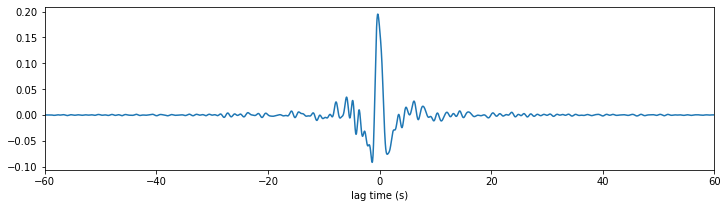

In [14]:
#choose day to get all ccfs in same group
day = np.datetime64('2010-12-01')

#get days and ccfs corresponding to the chosen day
days_cluster, ccfs_cluster = getCluster(day, days, labels, ccfs)

#plot mean CCF
fig, ax = plt.subplots(figsize=(12,3))

#create lag time array using sampling rate and maxlag
fs = params.cc_sampling_rate
sampint = 1.0/fs
maxlag = params.maxlag
lagtimes = np.arange(-1*maxlag, maxlag+sampint, sampint)

avg_cluster = np.mean(ccfs_cluster, axis=0) #get average ccf

ax.plot(lagtimes, avg_cluster)
ax.set_xlabel('lag time (s)')
ax.set_xlim(-60,60)


Can also plot interferogram of different CCFs in the cluster (useful to check how similar CCFs within each cluster are). Note that x-axis is basically a count of the CCFs in the cluster at this point, so adjacent CCFs here may not be adjacent in time.

Figure(864x864)
AxesSubplot(0.125,0.125;0.775x0.755)


/home/yatesal/cluster_CCFs/clusterCCFs_msnoise.py:250: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = ax.pcolormesh(df.index, df.columns, df.values.T, vmin=-clim, vmax=clim, rasterized=True,cmap='seismic')


Text(0.5, 0, 'CCF count')

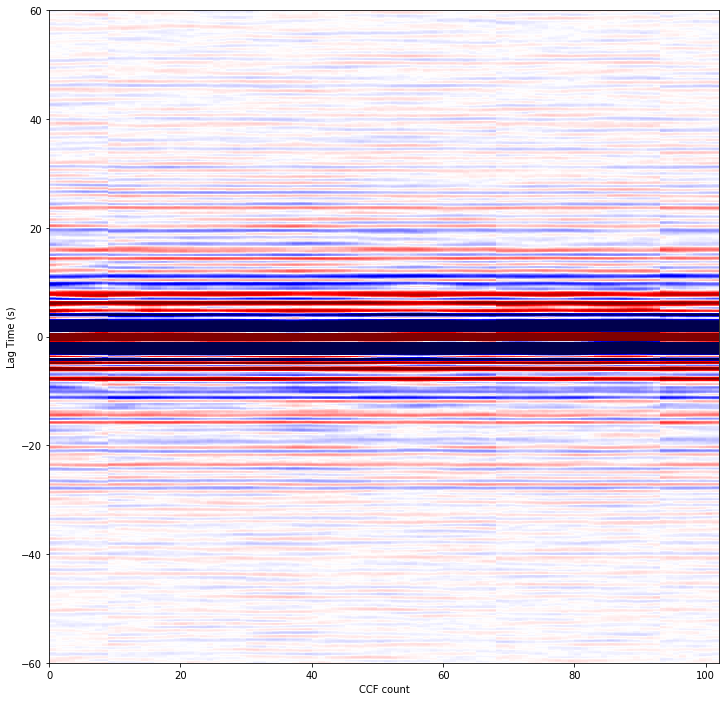

In [16]:
#plot interferogram of cluster
fig, ax = plt.subplots(figsize=(12,12))
x = np.arange(len(ccfs_cluster)) #plot by index rather than date

plot_interferogram(ccfs_cluster, params, x, fig=fig, ax=ax, maxlag=60)
ax.set_xlabel('CCF count')